# will they or won't they?

a simple machine learning model for predicting whether a user makes a prime day purchase, based off their captured behavior and whether they are an amazon user or not.

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_curve, roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score, average_precision_score
)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import xgboost as xgb
import warnings


In [2]:
# configs
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# fetch data from database

the training data has been prepared in the database. we will need to drop some columns from that data table:
- we cannot use the `user_id` column unique per observation and has no bearing on whether someone makes a purchase or not
- column `num_apps` is uniformly 1, so useless. drop that.
- columns 
- columns `num_countries`, `num_genders`, `num_age_groups` are just for sanity checking and are uniformly unity.
- i don't have time now to feature engineer the search terms into usuable features so leaving `all_searches_combined` out for now
- we're only going to predict whether a purchase was made or not. hence drop other purchase-related metrics:
    + `num_successful_orders`
    + `total_spend`
    + `num_categories_purchased`
    + `num_subcategories_purchased`
    + `num_brands_purchased`

(TODO: add boolean features and feature engineering based on natural languave processing of the search terms).

In [3]:
DATABASE_FILEPATH='../data/prime.ddb'
with duckdb.connect(DATABASE_FILEPATH) as con:
    df=(
        con.sql("SELECT * FROM training_data")
        .df()
        .drop(
            columns=[
                'user_id',
                'num_apps',
                'num_countries',
                'num_genders',
                'num_age_groups',
                'earliest_event',
                'latest_event',
                'all_searches_combined',
                'num_successful_orders',
                'total_spend',
                'num_categories_purchased',
                'num_subcategories_purchased',
                'num_brands_purchased'
            ]
        )
    )

In [4]:
df.columns

Index(['is_amazon_user', 'num_events', 'num_event_types', 'num_domains',
       'range_active_days', 'num_dates_active', 'prop_top_domains',
       'prop_rare_domains', 'prop_search_events', 'is_purchaser'],
      dtype='object')

In [5]:
print("dataset overview:")
print(f"Shape: {df.shape}")
print(df['is_purchaser'].value_counts(normalize=True))

dataset overview:
Shape: (993, 10)
is_purchaser
False    0.510574
True     0.489426
Name: proportion, dtype: float64


In [6]:
print(df.dtypes)

is_amazon_user           bool
num_events              int64
num_event_types         int64
num_domains             int64
range_active_days       int64
num_dates_active        int64
prop_top_domains      float32
prop_rare_domains     float32
prop_search_events    float32
is_purchaser             bool
dtype: object


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_amazon_user      993 non-null    bool   
 1   num_events          993 non-null    int64  
 2   num_event_types     993 non-null    int64  
 3   num_domains         993 non-null    int64  
 4   range_active_days   993 non-null    int64  
 5   num_dates_active    993 non-null    int64  
 6   prop_top_domains    993 non-null    float32
 7   prop_rare_domains   993 non-null    float32
 8   prop_search_events  993 non-null    float32
 9   is_purchaser        993 non-null    bool   
dtypes: bool(2), float32(3), int64(5)
memory usage: 52.5 KB


In [8]:
display(df.head())

,is_amazon_user,num_events,num_event_types,num_domains,range_active_days,num_dates_active,prop_top_domains,prop_rare_domains,prop_search_events,is_purchaser
0,True,8347,3,250,4,5,0.671858,0.328142,1.0,True
1,True,1671,3,68,6,7,0.336924,0.663076,1.0,True
2,True,94,2,8,0,1,0.382979,0.617021,1.0,True
3,True,96,2,15,5,6,0.052083,0.947917,1.0,True
4,True,1051,2,107,4,5,0.425309,0.574691,1.0,True


In [9]:
class PurchasePredictionPipeline:
    """
    a pipeline for predicting, from mixed categorical and numerical data, whether user made a purchase on prime day.
    """
    
    def __init__(self):
        self.models = {}
        self.preprocessor = None
        self.feature_names = None
        
    def create_preprocessor(self, X):
        """
        a preprocessing pipeline for mixed data types
        """
        
        # identify and separate out numerical and categorical columns
        numerical_features = X.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
        categorical_features = X.select_dtypes(include=['object']).columns.tolist() # none at present
        
        print(f"numerical features: {numerical_features}")
        print(f"categorical features: {categorical_features}")
        
        # preprocessing steps
        numerical_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
        
        # combine preprocessing steps
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        )
        
        return preprocessor


    def _get_feature_names(self, X):
        """
        feature names after preprocessing
        """
        feature_names = []
        
        # numerical features
        numerical_features = X.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
        feature_names.extend(numerical_features)
        
        # categorical features (after one-hot encoding)
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
        for col in categorical_features:
            unique_values = X[col].unique()
            # OneHotEncoder drops first category
            for val in sorted(unique_values)[1:]:
                feature_names.append(f"{col}_{val}")
        
        return feature_names

    def prepare_data(self, df, target_col='is_purchaser', test_size=0.2, random_state=42):
        """
        convert dataframe into training data shape, and split up testing/training data
        """
        
        # separate features and target
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        # separate out training data and testing data with random selection
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # preprocessor on all data 
        # (note the harmless leakage! test data is allowed to influence scaler ranges)
        self.preprocessor = self.create_preprocessor(X)
        
        # transform the data in scaled 
        X_train_processed = self.preprocessor.fit_transform(X_train)
        X_test_processed = self.preprocessor.transform(X_test)
        
        # store feature names in object data for later use
        self.feature_names = self._get_feature_names(X)
        
        return X_train_processed, X_test_processed, y_train, y_test
    
    
    def build_logistic_regression(self, X_train, y_train):
        """
        baseline model: logistic regression
        """
        
        print("\n" + "="*50)
        print("LOGISTIC REGRESSION")
        print("="*50)
        
        model = LogisticRegression(
            random_state=42,
            max_iter=1000,
            class_weight='balanced'  # class imbalance
        )
        
        model.fit(X_train, y_train)
        self.models['logistic_regression'] = model
        
        print("✓ logistic regression model trained")
        return model
    
    def build_random_forest(self, X_train, y_train):
        """
        comparison model no 1:  random forest
        """
        
        print("\n" + "="*50)
        print("RANDOM FOREST")
        print("="*50)
        
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        self.models['random_forest'] = model
        
        print("✓ random forest model trained")
        return model
    
    def build_xgboost(self, X_train, y_train):
        """
        comparison model no 2: XGBoost
        """
        
        print("\n" + "="*50)
        print("XGBOOST")
        print("="*50)
        
        # calculate scale_pos_weight for class imbalance
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        
        model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        self.models['xgboost'] = model
        
        print("✓ XGBoost model trained")
        return model
    
    def get_feature_importance(self, model_name):
        """
        feature importance reporting for tree-based models
        """
        
        if model_name not in self.models:
            print(f"Model {model_name} not found!")
            return None
        
        model = self.models[model_name]
        
        if model_name == 'random_forest':
            importance = model.feature_importances_
        elif model_name == 'xgboost':
            importance = model.feature_importances_
        else:
            print(f"Feature importance not available for {model_name}")
            return None
        
        # feature importance dataframe
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        return feature_importance_df
    
    def train_all_models(self, df):
        """
        run pipeline and train all models
        """
        
        print("STARTING TRAINING PIPELINE")
        print("="*50)
        
        # prepare data
        X_train, X_test, y_train, y_test = self.prepare_data(df)
        
        print(f"\nshape of training data: {X_train.shape}")
        print(f"shape of test data: {X_test.shape}")
        print(f"number of features after preprocessing: {X_train.shape[1]}")
        
        # train all models
        self.build_logistic_regression(X_train, y_train)
        self.build_random_forest(X_train, y_train)
        self.build_xgboost(X_train, y_train)
        
        print(f"\n" + "="*50)
        print("ALL MODELS TRAINED")
        print(f"Models available: {list(self.models.keys())}")
        print("="*50)
        
        return X_train, X_test, y_train, y_test


In [10]:
# Initialize and run the pipeline
pipeline = PurchasePredictionPipeline()
X_train, X_test, y_train, y_test = pipeline.train_all_models(df)

STARTING TRAINING PIPELINE
numerical features: ['is_amazon_user', 'num_events', 'num_event_types', 'num_domains', 'range_active_days', 'num_dates_active']
categorical features: []

shape of training data: (794, 6)
shape of test data: (199, 6)
number of features after preprocessing: 6

LOGISTIC REGRESSION
✓ logistic regression model trained

RANDOM FOREST
✓ random forest model trained

XGBOOST
✓ XGBoost model trained

ALL MODELS TRAINED
Models available: ['logistic_regression', 'random_forest', 'xgboost']


In [11]:
# Display feature importance for tree-based models
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

for model_name in ['random_forest', 'xgboost']:
    print(f"\n{model_name.upper()} - most important features:")
    importance_df = pipeline.get_feature_importance(model_name)
    if importance_df is not None:
        display(importance_df.head(5))

print(f"\n" + "="*50)
print("MODEL BUILDING COMPLETE!")
print("="*50)


FEATURE IMPORTANCE ANALYSIS

RANDOM_FOREST - most important features:


,feature,importance
0,is_amazon_user,0.914120
1,num_events,0.034641
3,num_domains,0.033437
5,num_dates_active,0.008490
4,range_active_days,0.006212



XGBOOST - most important features:


,feature,importance
0,is_amazon_user,0.947883
3,num_domains,0.013325
4,range_active_days,0.011522
1,num_events,0.010974
5,num_dates_active,0.008359



MODEL BUILDING COMPLETE!


In [12]:
class ModelEvaluator:
    """
    evaluation class for classification models
    """
    
    
    def __init__(self, models, X_train, X_test, y_train, y_test, feature_names=None):
        self.models = models
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.feature_names = feature_names or [f'feature_{i}' for i in range(X_train.shape[1])]
        self.predictions = {}
        self.probabilities = {}
        self.metrics = {}
    
    
    def generate_predictions(self):
        """
        predictions and probabilities for all models
        """
        
        print("="*50)
        print("INFERRING PREDICTIONS FROM ALL MODELS")
        print("="*50)
        
        for name, model in self.models.items():
            # predict the class
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]  # probability of positive class
            
            self.predictions[name] = y_pred
            self.probabilities[name] = y_pred_proba
            
            print(f"✓ inferred predictions for {name}")
        
        print("predictions generated\n")
    
    def calculate_metrics(self):
        """
        comprehensive metrics for all models
        """
        
        print("="*50)
        print("PERFORMANCE METRICS")
        print("="*50)
        
        metrics_data = []
        
        for name in self.models.keys():
            y_pred = self.predictions[name]
            y_pred_proba = self.probabilities[name]
            
            # model quality metrics
            accuracy = accuracy_score(self.y_test, y_pred)                 # do not use
            precision = precision_score(self.y_test, y_pred)               # how many predicted to purchase, actually did purchase?
            recall = recall_score(self.y_test, y_pred)                     # how many actually purchasing were predicted to do so?
            f1 = f1_score(self.y_test, y_pred)                             # a balance of precision and recall
            auc_roc = roc_auc_score(self.y_test, y_pred_proba)             # area under receiver-operator curve
            auc_pr = average_precision_score(self.y_test, y_pred_proba)    # average precision score
            
            metrics_data.append({
                'model': name,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1-score': f1,
                'ROC-AUC': auc_roc,
                'PR-AUC': auc_pr
            })
            
            self.metrics[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': auc_roc,
                'pr_auc': auc_pr
            }
        
        self.metrics_df = pd.DataFrame(metrics_data)
        
        print("all metrics calculated\n")
        return self.metrics_df
    
    def cross_validation_scores(self, cv_folds=5):
        """
        cross-validation score for models
        """
        
        print("="*50)
        print("CROSS-VALIDATION")
        print("="*50)
        
        cv_results = {}
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        # combine train and test sets for CV
        X_full = np.vstack([self.X_train, self.X_test])
        y_full = np.hstack([self.y_train, self.y_test])
        
        for name, model in self.models.items():
            # perform cross-validation for multiple metrics
            cv_accuracy = cross_val_score(model, X_full, y_full, cv=skf, scoring='accuracy')
            cv_f1 = cross_val_score(model, X_full, y_full, cv=skf, scoring='f1')
            cv_roc_auc = cross_val_score(model, X_full, y_full, cv=skf, scoring='roc_auc')
            
            cv_results[name] = {
                'accuracy_mean': cv_accuracy.mean(),
                'accuracy_std': cv_accuracy.std(),
                'f1_mean': cv_f1.mean(),
                'f1_std': cv_f1.std(),
                'roc_auc_mean': cv_roc_auc.mean(),
                'roc_auc_std': cv_roc_auc.std()
            }
            
            print(f"{name}:")
            print(f"  accuracy: {cv_accuracy.mean():.4f} (±{cv_accuracy.std():.4f})")
            print(f"  f1-Score: {cv_f1.mean():.4f} (±{cv_f1.std():.4f})")
            print(f"  ROC-AUC:  {cv_roc_auc.mean():.4f} (±{cv_roc_auc.std():.4f})")

        
        self.cv_results = cv_results
        return cv_results
    
    def plot_confusion_matrices(self):
        """
        confusion matrices for all models
        """
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle('confusion matrices comparison', fontsize=16, fontweight='bold')
        
        for idx, (name, y_pred) in enumerate(self.predictions.items()):
            cm = confusion_matrix(self.y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['no purchase', 'purchase'],
                       yticklabels=['no purchase', 'purchase'],
                       ax=axes[idx])
            
            axes[idx].set_title(f'{name.replace("_", " ").title()}')
            axes[idx].set_xlabel('predicted')
            axes[idx].set_ylabel('actual')
        
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curves(self):
        """
        plot ROC curves
        """
        
        plt.figure(figsize=(10, 8))
        
        for name, y_pred_proba in self.probabilities.items():
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
            auc_score = roc_auc_score(self.y_test, y_pred_proba)
            
            plt.plot(fpr, tpr, linewidth=2, 
                    label=f'{name.replace("_", " ").title()} (AUC = {auc_score:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('false positive rate', fontsize=12)
        plt.ylabel('true positive rate', fontsize=12)
        plt.title('ROC comparison', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_precision_recall_curves(self):
        """
        plotting precision-recall curves
        """
        
        plt.figure(figsize=(10, 8))
        
        for name, y_pred_proba in self.probabilities.items():
            precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba)
            avg_precision = average_precision_score(self.y_test, y_pred_proba)
            
            plt.plot(recall, precision, linewidth=2,
                    label=f'{name.replace("_", " ").title()} (AP = {avg_precision:.3f})')
        
        # Baseline (random classifier)
        baseline = (self.y_test == 1).mean()
        plt.axhline(y=baseline, color='k', linestyle='--', linewidth=1, 
                   label=f'random classifier (AP = {baseline:.3f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('recall', fontsize=12)
        plt.ylabel('precision', fontsize=12)
        plt.title('precision-recall curves', fontsize=14, fontweight='bold')
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_feature_importance_comparison(self):
        """
        compare feature importance across tree-based models
        """
        
        tree_models = ['random_forest', 'xgboost']
        available_models = [name for name in tree_models if name in self.models.keys()]
        
        if len(available_models) < 2:
            print("need at least 2 tree-based models for comparison")
            return
        
        fig, axes = plt.subplots(1, len(available_models), figsize=(6*len(available_models), 8))
        if len(available_models) == 1:
            axes = [axes]
        
        for idx, model_name in enumerate(available_models):
            model = self.models[model_name]
            importance = model.feature_importances_
            
            # Create feature importance dataframe
            feature_importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            # Plot horizontal bar chart
            axes[idx].barh(range(len(feature_importance_df)), 
                          feature_importance_df['importance'])
            axes[idx].set_yticks(range(len(feature_importance_df)))
            axes[idx].set_yticklabels(feature_importance_df['feature'])
            axes[idx].set_xlabel('feature importance')
            axes[idx].set_title(f'{model_name.replace("_", " ").title()}\nfeature importance')
            axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_prediction_confidence(self):
        """
        analyze prediction confidence distributions
        """
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('prediction confidence distributions', fontsize=16, fontweight='bold')
        
        for idx, (name, probabilities) in enumerate(self.probabilities.items()):
            # separate probabilities by actual class
            prob_no_purchase = probabilities[self.y_test == 0]
            prob_purchase = probabilities[self.y_test == 1]
            
            axes[idx].hist(prob_no_purchase, bins=30, alpha=0.7, 
                          label='no purchase (actual)', color='lightcoral')
            axes[idx].hist(prob_purchase, bins=30, alpha=0.7, 
                          label='purchase (actual)', color='lightblue')
            
            axes[idx].set_xlabel('predicted probability of purchase')
            axes[idx].set_ylabel('frequency')
            axes[idx].set_title(f'{name.replace("_", " ").title()}')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_detailed_report(self):
        """
        model evaluation report
        """
        
        print("\n" + "="*50)
        print("MODEL EVALUATION REPORT")
        print("="*50)
        
        # metrics comparison
        print("\n1. PERFORMANCE METRICS COMPARISON")
        print("-"*50)
        print(self.metrics_df.round(4).to_string(index=False))
        
        # Best model identification
        print(f"\n2. BEST MODEL BY METRIC")
        print("-"*50)
        for metric in ['accuracy', 'precision', 'recall', 'f1-Score', 'ROC-AUC', 'PR-AUC']:
            best_model = self.metrics_df.loc[self.metrics_df[metric].idxmax(), 'model']
            best_score = self.metrics_df[metric].max()
            print(f"{metric:12}: {best_model:15} ({best_score:.4f})")
        
        # cross-validation results
        if hasattr(self, 'cv_results'):
            print(f"\n3. CROSS-VALIDATION RESULTS ({5}-FOLD)")
            print("-"*50)
            for name, results in self.cv_results.items():
                print(f"\n{name.replace('_', ' ').title()}:")
                print(f"  accuracy: {results['accuracy_mean']:.4f} (±{results['accuracy_std']:.4f})")
                print(f"  f1-Score: {results['f1_mean']:.4f} (±{results['f1_std']:.4f})")
                print(f"  ROC-AUC:  {results['roc_auc_mean']:.4f} (±{results['roc_auc_std']:.4f})")
        
        # feature importance insights for tree models
        print(f"\n4. KEY INSIGHTS FROM FEATURE IMPORTANCE")
        print("-"*50)
        
        tree_models = ['random_forest', 'xgboost']
        for model_name in tree_models:
            if model_name in self.models:
                model = self.models[model_name]
                importance = model.feature_importances_
                
                # Get top 3 features
                top_indices = np.argsort(importance)[-3:][::-1]
                
                print(f"\n{model_name.replace('_', ' ').title()} - top 3 features:")
                for i, idx in enumerate(top_indices, 1):
                    print(f"  {i}. {self.feature_names[idx]}: {importance[idx]:.4f}")
        
        # model recommendations
        print(f"\n5. MODEL RECOMMENDATIONS")
        print("-"*50)
        
        # Find overall best model (weighted average of key metrics)
        weights = {'f1-Score': 0.3, 'ROC-AUC': 0.3, 'PR-AUC': 0.25, 'precision': 0.15}
        weighted_scores = {}
        
        for _, row in self.metrics_df.iterrows():
            model_name = row['Model']
            weighted_score = sum(row[metric] * weight for metric, weight in weights.items())
            weighted_scores[model_name] = weighted_score
        
        best_overall = max(weighted_scores.keys(), key=lambda x: weighted_scores[x])
        
        print(f"\noverall best model: {best_overall.replace('_', ' ').title()}")
        print(f"weighted score: {weighted_scores[best_overall]:.4f}")
        
        print(f"\nmodel-specific insights:")
        print(f"• logistic regression: baseline, interpretable coefficients")
        print(f"• random forest: handles feature interactions, feature type diversity, robust to outliers")
        print(f"• XGBoost: often best performance, handles imbalanced data well")
        
        print("\n"+"="*50)
    
    def run_complete_evaluation(self):
        """run the complete evaluation pipeline."""
        
        print("="*50)
        print("STARTING MODEL EVALUATION")
        print("="*50)
        
        # generate predictions
        self.generate_predictions()
        
        # compute metrics
        self.calculate_metrics()
        
        # cross-validation
        self.cross_validation_scores()
        
        # generate plots
        print("VISUALIZATION PLOTS")
        print("="*50)
        
        self.plot_confusion_matrices()
        self.plot_roc_curves()
        self.plot_precision_recall_curves()
        # self.plot_feature_importance_comparison()
        self.analyze_prediction_confidence()
        
        # generate comprehensive report
        self.generate_detailed_report()
        
        return self.metrics_df

In [13]:
pipeline.models

{'logistic_regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 'random_forest': RandomForestClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=2, min_samples_split=5, n_jobs=-1,
                        random_state=42),
 'xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               

STARTING MODEL EVALUATION
INFERRING PREDICTIONS FROM ALL MODELS
✓ inferred predictions for logistic_regression
✓ inferred predictions for random_forest
✓ inferred predictions for xgboost
predictions generated

PERFORMANCE METRICS
all metrics calculated

CROSS-VALIDATION
logistic_regression:
  accuracy: 0.9929 (±0.0040)
  f1-Score: 0.9929 (±0.0041)
  ROC-AUC:  0.9929 (±0.0054)
random_forest:
  accuracy: 0.9929 (±0.0040)
  f1-Score: 0.9929 (±0.0041)
  ROC-AUC:  0.9926 (±0.0056)
xgboost:
  accuracy: 0.9929 (±0.0040)
  f1-Score: 0.9929 (±0.0041)
  ROC-AUC:  0.9942 (±0.0044)
VISUALIZATION PLOTS


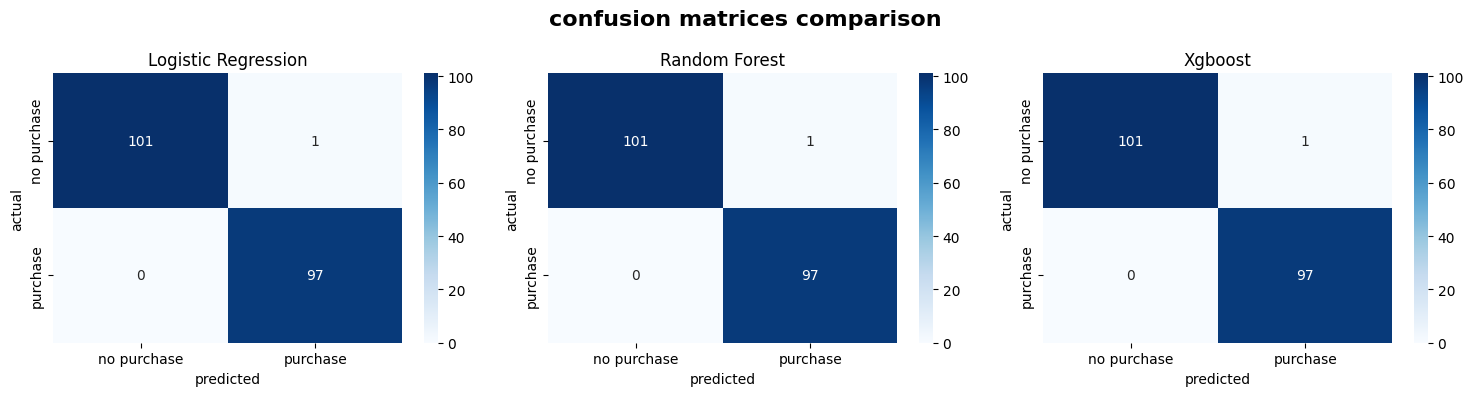

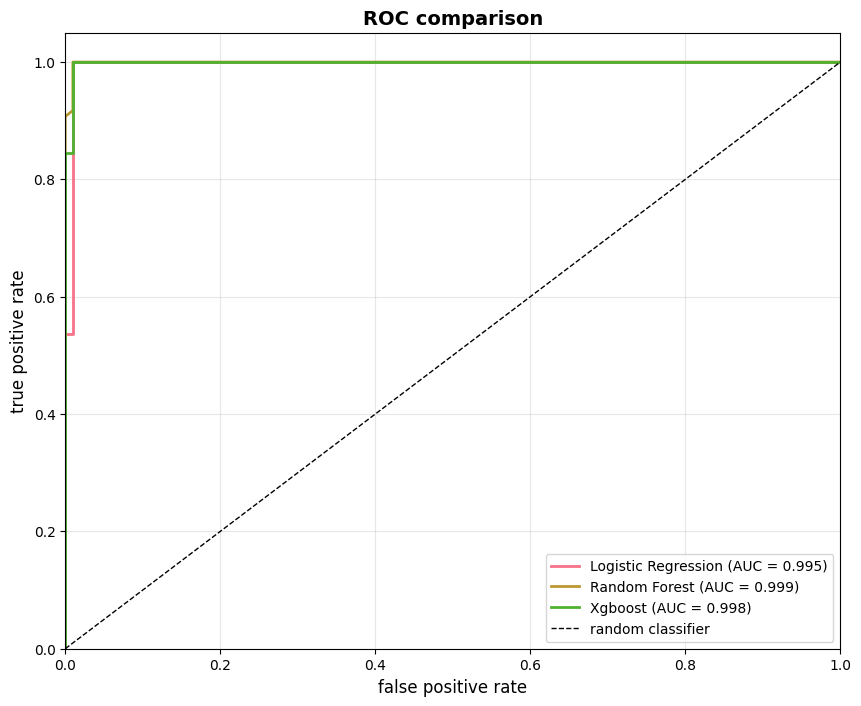

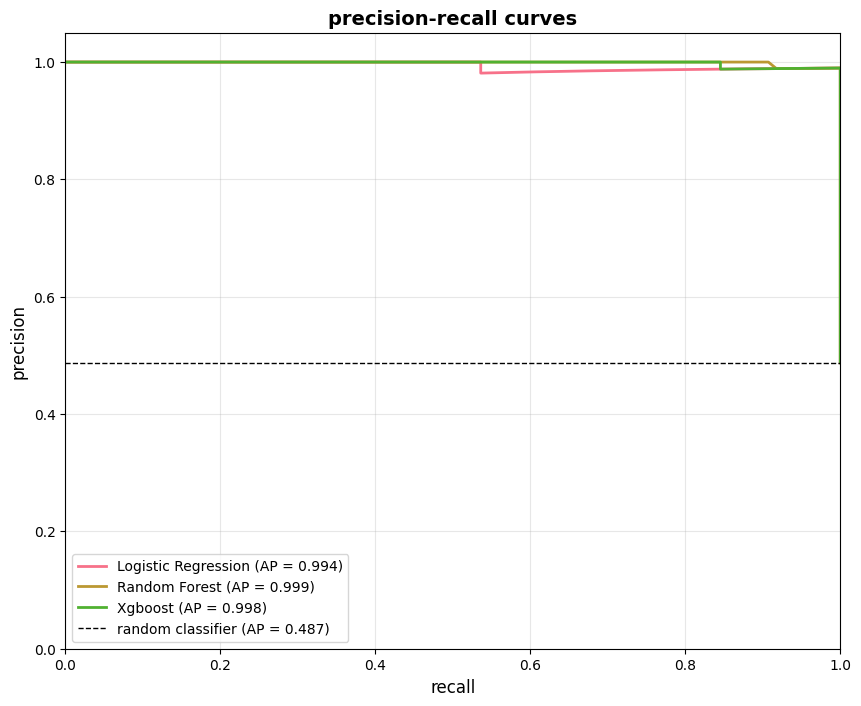

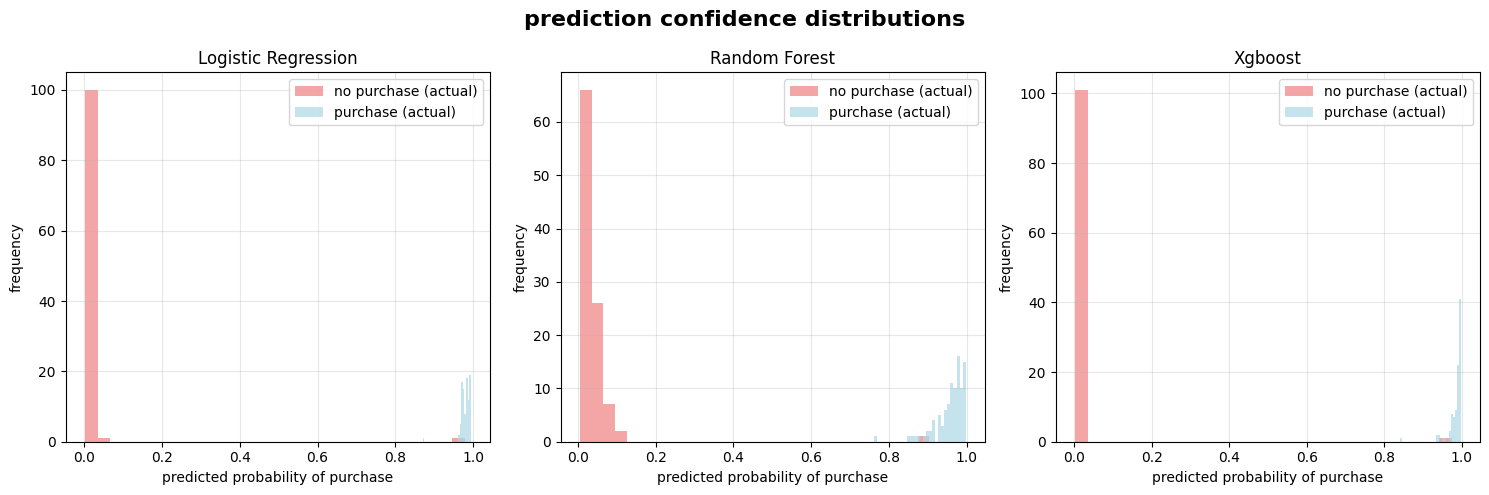


MODEL EVALUATION REPORT

1. PERFORMANCE METRICS COMPARISON
--------------------------------------------------
              model  accuracy  precision  recall  Ff1-score  ROC-AUC  PR-AUC
logistic_regression     0.995     0.9898     1.0     0.9949   0.9955  0.9937
      random_forest     0.995     0.9898     1.0     0.9949   0.9991  0.9990
            xgboost     0.995     0.9898     1.0     0.9949   0.9985  0.9983

2. BEST MODEL BY METRIC
--------------------------------------------------
accuracy    : logistic_regression (0.9950)
precision   : logistic_regression (0.9898)
recall      : logistic_regression (1.0000)


KeyError: 'f1-Score'

In [14]:
# choose features
feature_names = ['is_amazon_user', 'num_events', 'num_event_types', 'num_domains', 'range_active_days', 
                'num_dates_active', 'prop_top_domains', 'prop_rare_domains', 'prop_search_events']

evaluator = ModelEvaluator(
    models=pipeline.models,  # Your trained models
    X_train=X_train,
    X_test=X_test, 
    y_train=y_train,
    y_test=y_test,
    feature_names=feature_names
)

# Run complete evaluation
results_df = evaluator.run_complete_evaluation()


In [ ]:

# Example usage (uncomment and modify these lines to use with your trained models):
"""
# Assuming you have your trained models in a dictionary called 'models'
# and your data splits as X_train, X_test, y_train, y_test

# Your feature names
feature_names = ['num_events', 'num_event_types', 'num_domains', 'range_active_days', 
                'num_dates_active', 'prop_top_domains', 'prop_rare_domains', 'prop_search_events']

# Initialize evaluator
evaluator = ModelEvaluator(
    models=pipeline.models,  # Your trained models dictionary
    X_train=X_train,
    X_test=X_test, 
    y_train=y_train,
    y_test=y_test,
    feature_names=feature_names
)

# Run complete evaluation
results_df = evaluator.run_complete_evaluation()
"""

print("Model Evaluation Framework Ready!")
print("="*50)
print("Instructions:")
print("1. Make sure your models are trained and stored in a dictionary")
print("2. Update the feature_names list with your actual feature names")
print("3. Initialize the ModelEvaluator with your data and models")
print("4. Run evaluator.run_complete_evaluation() for complete analysis")
print("="*50)